In [ ]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [1]:
# Inspect the input data
import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import normalizeIMG, real_files_to_tensors, window_mean
from utils import minmax_normalize_param, unnormalize_params

from models import encoderDecoderModel

# some initializations
data_dir = './tomo_data/REAL_DATA_Run2'

IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

zeropad = 14
start_turn = 1
skipturns = 3
Ib = 1.16e11

normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

E_normFactor = 25000000000.0
B_normFactor = 800000000.0
T_normFactor = 28000000000.0

var_names = ['phEr', 'enEr', 'bl','inten', 'Vrf', 'mu', 'VrfSPS']
loss_weights = [0, 1, 2, 3, 4, 5, 6]

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'best_encoder_TF'
dec_timestamp = 'best_decoder_TF'


2023-03-10 13:09:20.575440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 13:09:20.823356: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 13:09:20.856434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-03-10 13:09:20

In [2]:

wf_test_orig, wf_id, bunch_profiles_orig = real_files_to_tensors(data_dir,
                                                                 Ib=Ib, 
                                                                 T_normFactor=T_normFactor)
print(wf_test_orig.shape)
print(bunch_profiles_orig.shape)
print('Max value in wf: ', np.max(wf_test_orig))
print('Min value in wf: ', np.min(wf_test_orig))

# Smoothen the input data
window = 5
wf_test = np.copy(wf_test_orig)
wf_test = wf_test.reshape(-1, IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE)
for i in range(len(wf_test)):
    wf_test[i] = window_mean(wf_test[i], W=window, axis=0, zeropad=zeropad)

bunch_profiles = np.copy(bunch_profiles_orig)
bunch_profiles = bunch_profiles.reshape(-1, IMG_OUTPUT_SIZE, bunch_profiles_orig.shape[2])
for i in range(len(bunch_profiles)):
    bunch_profiles[i] = window_mean(bunch_profiles[i], W=window, axis=0, zeropad=zeropad)


(48, 128, 128, 1)
(48, 128, 326, 1)
Max value in wf:  0.17276743
Min value in wf:  -0.008477643


2023-03-10 13:09:32.941980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-03-10 13:09:32.942154: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 13:09:32.942171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-03-10 13:09:32.942826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

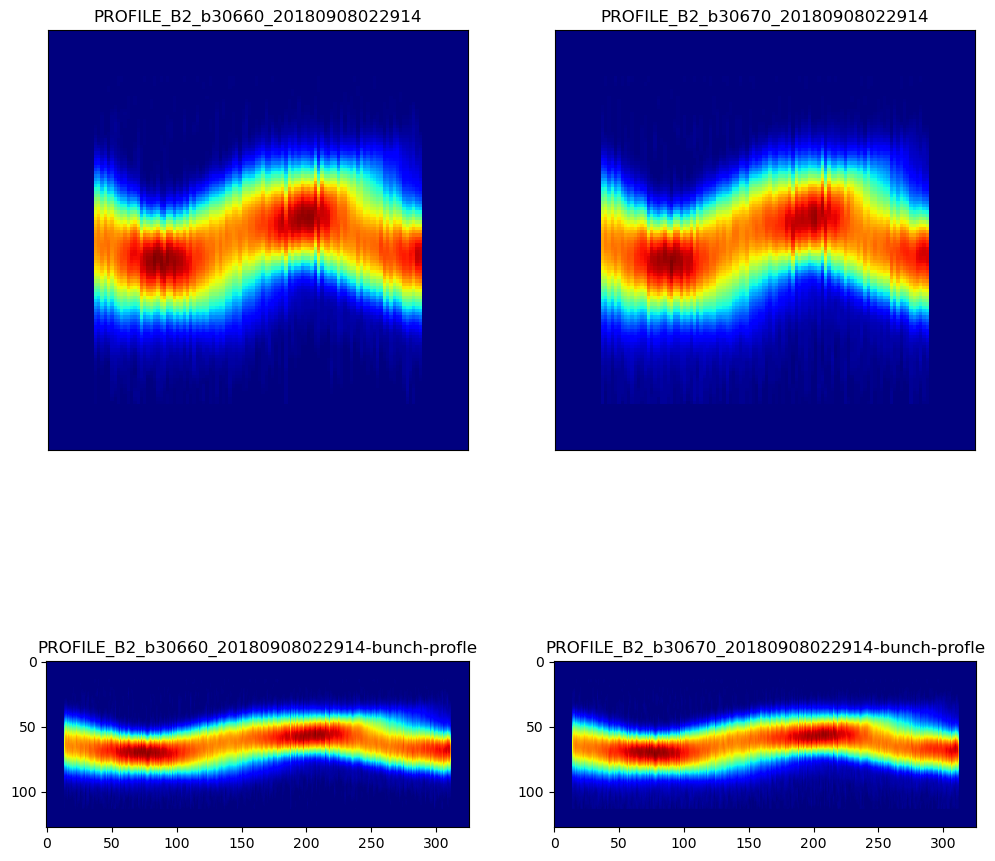

In [3]:
%matplotlib inline
# plot some of the outputs

nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in sample[i]])
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    ax.imshow(bunch_profiles_orig[sample[i]], cmap='jet')
    ax.set_title(f'{wf_id[i]}-bunch-profle')


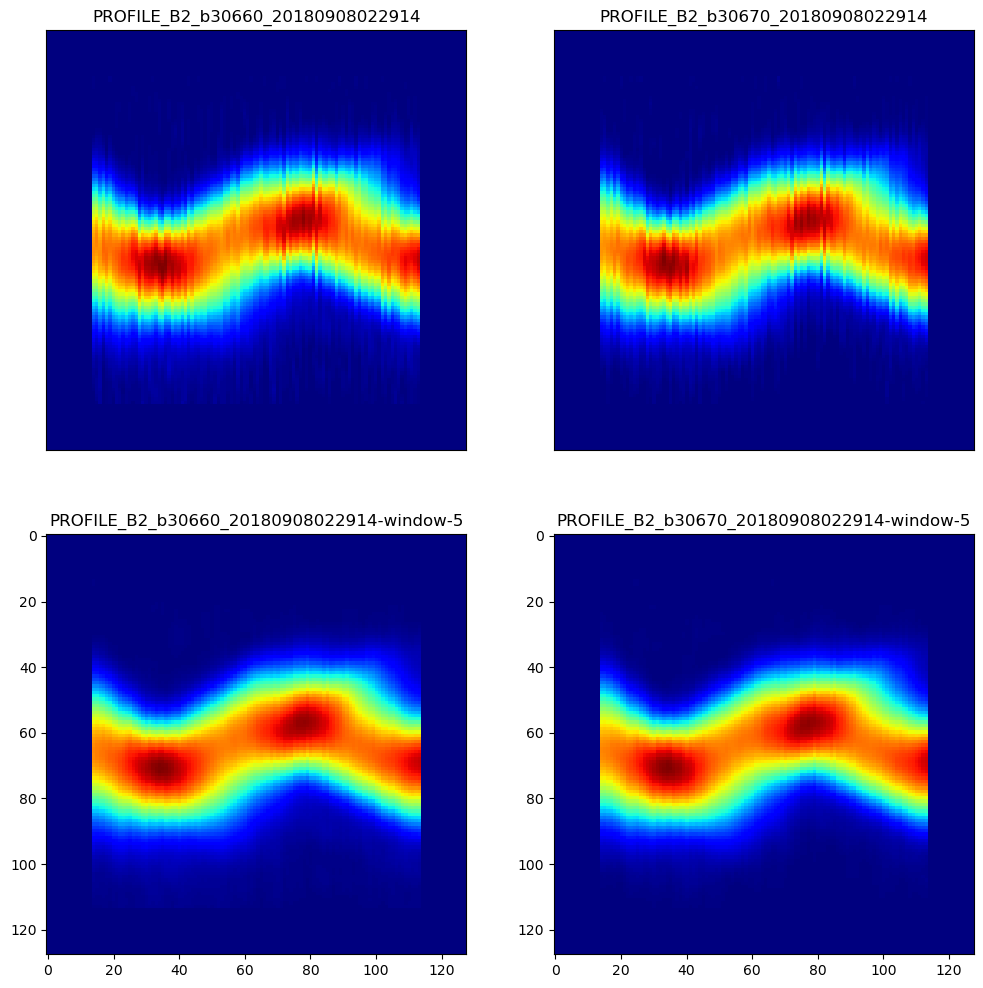

In [4]:


nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(samples_X[i], cmap='jet')
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    window = 5
    averaged = window_mean(samples_X[i].numpy().reshape(128, 128), window, axis=0)
    ax.imshow(averaged, cmap='jet')
    ax.set_title(f'{wf_id[i]}-window-{window}')

    # print(averaged.shape)
    # break
    # Set the label


## Testing the models on the real data

In [5]:
# Load the model
print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir,
 loss_weights=loss_weights)


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF


In [6]:
# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(1, 298, num=28, endpoint=True, dtype=np.float32)
print(selected_turns)
norm_turns = minmax_normalize_param(selected_turns, np.min(selected_turns),
                                    np.max(selected_turns),
                                    target_range=(0, 1))


[  1.  12.  23.  34.  45.  56.  67.  78.  89. 100. 111. 122. 133. 144.
 155. 166. 177. 188. 199. 210. 221. 232. 243. 254. 265. 276. 287. 298.]


In [7]:
def visual_evaluation(wf, wf_id, latent_pred, ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, figsize=(12, 5), 
                            gridspec_kw={'width_ratios': [5, 2, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)
    
    # # start with left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    plt.xticks([], []); plt.yticks([], [])

    # center plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    plt.table(cellText=latent_pred_unnorm, rowLabels=rowLabels,
        colLabels=['Value'], loc='center')

    # top right plot
    plt.sca(axes[2])
    # print(f'PS Pred, min: {np.min(ps_pred)}, max: {np.max(ps_pred)}')
    plt.imshow(ps_pred, cmap='jet', vmin=-1, vmax=1)
    plt.title(f'Pred PS, Turn: {turn}', fontsize=14)
    plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


In [11]:
from utils import minMaxScaleIMG
def assess_model_real_data(wf, wf_id, bunch_profile, latent_pred, 
                           ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 5),
                            gridspec_kw={'width_ratios': [5, 4, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)
    
    # print(latent_pred_unnorm.shape)
    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    # plt.xticks([], []); plt.yticks([], [])

    # top right plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    plt.table(cellText=latent_pred_unnorm, rowLabels=rowLabels,
        colLabels=['Value'], loc='center')

    # bottome right plot 
    plt.sca(axes[2])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))

    # Which turn? 
    target_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1]- zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    
    plt.plot(time_profile_pred, label='Prediction')
    # plt.plot(time_profile_target, label='Target 100 trn', marker='')
    plt.plot(bunch_profile_target, label='Target 300 trn', marker='')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    # plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [12]:
from utils import minMaxScaleIMG


def assess_model_real_data_no_table(wf, wf_id, bunch_profile, latent_pred, 
                                    ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3),
                             gridspec_kw={'width_ratios': [5, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)

    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id.split("PROFILE_")[1]}', fontsize=12)
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()


    # bottome right plot
    plt.sca(axes[1])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))
    # time_profile_pred = np.sum(ps_pred[:, :, 0], 0)


    # Which turn?
    target_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1] - zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    # bunch_profile_target = (bunch_profile[:, bunch_profile_turn])

    plt.plot(time_profile_pred, label='PRED')
    # plt.plot(time_profile_target, label='Target 100 trn', marker='')
    plt.plot(bunch_profile_target, label='TRUE', marker='')
    # Also plot the diff
    plt.plot(np.abs(time_profile_pred - bunch_profile_target), label='DIFF')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


In [15]:
# Plot the predictions
out_dir = 'plots/real_data_smooth'
for norm_turn in norm_turns[:1]:
    # expand turns to be equal to the number of test points
    turn_test = np.ones(len(wf_test), dtype=np.float32)*norm_turn
    # get the predictions
    # start_t = time.time()
    latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)
    # end_t = time.time()
    # print('Time taken:' , end_t - start_t)
    # Now I need to plot them
    # one directory per WF
    for i in np.arange(len(wf_test))[:]:
        # unnorm_turn = int(unnormalizeTurn(norm_turn, maxTurns=298))
        unnorm_turn = int(minmax_normalize_param(norm_turn, 0, 1, target_range=(1, 298)))
        # print(unnorm_turn)
        # save in a figure the turn, latents, input image, output image
        os.makedirs(out_dir + f'/{wf_id[i]}', exist_ok=True)
        # figname = out_dir+ f'/{wf_id[i]}/time_profile_{unnorm_turn:03d}.png'
        # assess_model_real_data_no_table(wf_test[i], wf_id[i], bunch_profiles[i],
        #                 latent_pred[i], ps_pred[i], 
        #                 unnorm_turn, figname, savefig=True)

        figname = out_dir+ f'/{wf_id[i]}/latents_time_projection_{unnorm_turn:03d}.png'
        assess_model_real_data(wf_test[i], wf_id[i], bunch_profiles[i],
                        latent_pred[i], ps_pred[i], 
                        unnorm_turn, figname, savefig=True)

        # figname = f'plots/real_data_smooth/{wf_id[i]}/turn_{unnorm_turn:03d}.png'
        # visual_evaluation(wf_test[i], wf_id[i], 
        #                 latent_pred[i], ps_pred[i], 
        #                 unnorm_turn, figname, savefig=False)
        # break


        

In [44]:
# compress in a gif
os.system('cd plots/real_data_smooth; for dir in *; do cd $dir; pwd; convert -delay 20 -loop 0 time_profile_???.png all_time_profiles.gif; cd ..; done')


PROFILE_B2_b30660_20180908022914
PROFILE_B2_b30670_20180908022914
PROFILE_B2_b30680_20180908022914
PROFILE_B2_b30690_20180908022914
PROFILE_B2_b30700_20180908022914
PROFILE_B2_b30710_20180908022914
PROFILE_B2_b30720_20180908022914
PROFILE_B2_b30730_20180908022914
PROFILE_B2_b30740_20180908022914
PROFILE_B2_b30750_20180908022914
PROFILE_B2_b30760_20180908022914
PROFILE_B2_b30770_20180908022914
PROFILE_B2_b30780_20180908022914
PROFILE_B2_b30790_20180908022914
PROFILE_B2_b30800_20180908022914
PROFILE_B2_b30810_20180908022914
PROFILE_B2_b30820_20180908022914
PROFILE_B2_b30830_20180908022914
PROFILE_B2_b30840_20180908022914
PROFILE_B2_b30850_20180908022914
PROFILE_B2_b30860_20180908022914
PROFILE_B2_b30870_20180908022914
PROFILE_B2_b30880_20180908022914
PROFILE_B2_b30890_20180908022914
PROFILE_B2_b30900_20180908022914
PROFILE_B2_b30910_20180908022914
PROFILE_B2_b30920_20180908022914
PROFILE_B2_b30930_20180908022914
PROFILE_B2_b30940_20180908022914
PROFILE_B2_b30950_20180908022914
PROFILE_B2

0

_b30980_20180908022914
PROFILE_B2_b30990_20180908022914
PROFILE_B2_b31000_20180908022914
PROFILE_B2_b31010_20180908022914
PROFILE_B2_b31020_20180908022914
PROFILE_B2_b31030_20180908022914
PROFILE_B2_b31040_20180908022914
PROFILE_B2_b31050_20180908022914
PROFILE_B2_b31060_20180908022914
PROFILE_B2_b31070_20180908022914
PROFILE_B2_b31080_20180908022914
PROFILE_B2_b31090_20180908022914
PROFILE_B2_b31100_20180908022914
PROFILE_B2_b31110_20180908022914
PROFILE_B2_b31120_20180908022914
PROFILE_B2_b31130_20180908022914


## Plot evolution of latent space params per bunch


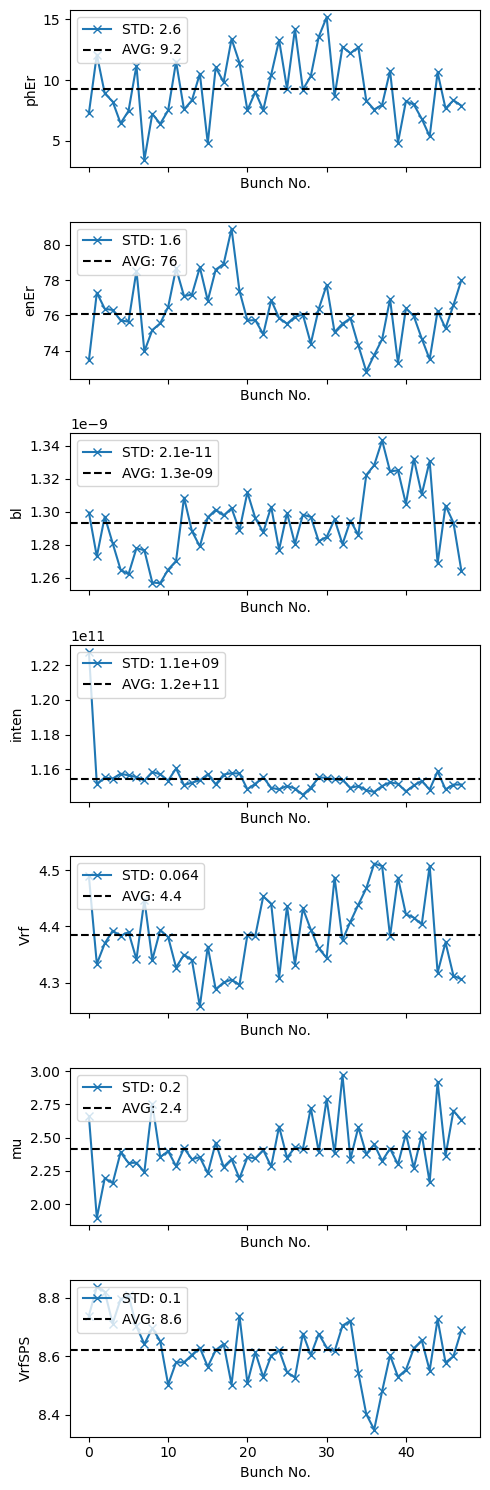

In [16]:
# Get latents for all input data
latent_pred = encDec.encode(wf_test, unnormalize=True)

fig, axes = plt.subplots(ncols=1, nrows=len(loss_weights), figsize=(5, 15), sharex=True)

# bunch_ids = [name.split(''for name in wf_id]

for lat_id in range(latent_pred.shape[1]):
    y = latent_pred[:, lat_id]
    var_name = var_names[loss_weights[lat_id]]
    ax = axes[lat_id]
    plt.sca(ax)
    # plt.title(var_name)
    plt.ylabel(var_name)
    mean = np.mean(y)
    std = np.std(y)
    plt.plot(y, marker='x', label=f'STD: {std:.2g}')
    plt.axhline(y=mean, label=f'AVG: {mean:.2g}', color='0', ls='--')
    plt.xlabel('Bunch No.')
    plt.legend(loc='upper left')
    # plt.xticks(np.arange(len(y)))
    plt.tight_layout()

plt.savefig(out_dir + '/bunch-by-bunch-variation.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

## Compare real data to simulation data

In [ ]:
from utils import encoder_files_to_tensors, sample_files
# data_dir = './tomo_data/datasets_encoder_TF_16-12-22'
data_dir = './tomo_data/datasets_encoder_TF_03-03-23'

dataset_percent = 1
num_Turns_Case = 1
normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

# real data: wf_test
real_x = wf_test
real_id = wf_id


In [ ]:
# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
assert os.path.exists(TRAINING_PATH)


# First the training data
file_names = sample_files(
    TRAINING_PATH, dataset_percent, keep_every=num_Turns_Case)
print(len(file_names))
start_t = time.time()
# read input, divide in features/ label, create tensors
sim_x, sim_y = encoder_files_to_tensors(file_names, normalization=normalization,
                                          img_normalize=img_normalize)
sim_x = np.array(sim_x).reshape(-1, 128, 128)
sim_y = np.array(sim_y)
total_time = time.time() - start_t
print(
    f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


In [ ]:
# Now for every real_x, I need to find a sim_x that is as close as possible
# One metric to use is sum(diff(x1, x2))
min_diff_idx = [-1] * len(real_x)
min_diff_sum = [128 * 128] * len(real_x)

for i in range(len(real_x)):
    for j in range(len(sim_x)):
        diff_sum = np.sum(np.abs(real_x[i][14:-14,14:-14] - sim_x[j][14:-14,14:-14]))
        if diff_sum < min_diff_sum[i]:
            min_diff_sum[i] = diff_sum
            min_diff_idx[i] = j

In [ ]:
# Get the predictions for real and sim data
real_latents = encDec.encode(real_x, unnormalize=True).numpy()
sim_latents = sim_y[min_diff_idx]
sim_latents_unnorm = np.array(unnormalize_params(
        sim_latents[:, 0], sim_latents[:, 1], sim_latents[:, 2],
        sim_latents[:, 3], sim_latents[:, 4], sim_latents[:, 5],
        sim_latents[:, 6], normalization=normalization)).T

In [ ]:
nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(real_x)),
                          size=nrows, replace=False)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(10, 20), sharex=True)
# axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i, 0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(real_x[sample[i]], cmap='jet')
    ax.set_title(f'{real_id[sample[i]]}')
    plt.tight_layout()

    ax = axes[i, 1]
    plt.sca(ax)
    plt.tight_layout()

    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(sim_x[min_diff_idx[sample[i]]], cmap='jet')
    # title = ','.join([f'{y:.2f}' for y in sim_y[min_diff_idx[sample[i]]]])
    ax.set_title(f'Sim')

    ax = axes[i, 2]
    plt.sca(ax)
    plt.axis('off')

    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    predicted = real_latents[sample[i]]
    simulated = sim_latents_unnorm[sample[i]]
    cellText = [[f'{predicted[i]:.3g}', f'{simulated[loss_weights[i]]:.3g}'] for i in range(len(predicted))]
    plt.table(cellText=cellText, rowLabels=rowLabels,
              colLabels=['Predicted', 'Simulation'], loc='center')
    plt.tight_layout()


## Experimentation

In [ ]:
fname = os.path.join(data_dir, 'PROFILE_B2_b30660_20180908022914.npy')

with open(fname, 'rb') as f:
    timeScale_for_tomo = np.load(f)
    BunchProfiles = np.load(f)

origProfiles = BunchProfiles.copy()

fig, ax_arr = plt.subplots(ncols=3)
plt.sca(ax_arr[0])
plt.plot(timeScale_for_tomo)

plt.sca(ax_arr[1])
plt.plot(origProfiles[:, 0])

# plt.show()
# print(timeScale_for_tomo.shape)
# print(BunchProfiles.shape)

BunchProfiles = BunchProfiles*Ib/np.sum(BunchProfiles[:, 0])
plt.sca(ax_arr[2])
plt.plot(BunchProfiles[:, 0])

# print(BunchProfiles.shape)


In [ ]:
def getTimgForModelFromDataFile(BunchProfiles, T_normFactor, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns, centroid_offset=0):
    # timeScale_for_tomo, BunchProfiles = getTimeProfiles_FromData(fname, Ib)
    BunchProfiles = BunchProfiles/T_normFactor
    sel_turns = np.arange(start_turn, skipturns *
                          (IMG_OUTPUT_SIZE-2*zeropad), skipturns).astype(np.int32)
    T_img = np.pad(BunchProfiles[:, sel_turns], ((zeropad-centroid_offset, zeropad +
                                                  centroid_offset), (zeropad, zeropad)), 'constant', constant_values=(0, 0))
    # T_img_ForModel = normalizeIMG(np.reshape(T_img, T_img.shape+(1,)))
    T_img_ForModel = np.reshape(T_img, T_img.shape+(1,))
    return T_img_ForModel

origTimg = getTimgForModelFromDataFile(origProfiles, 1, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns)
adjustedTimg = getTimgForModelFromDataFile(BunchProfiles, 1, IMG_OUTPUT_SIZE, zeropad, start_turn, skipturns)



In [ ]:
print(origTimg.shape)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = np.ravel(axes)
ax = axes[0]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(origTimg, cmap='jet')
print(np.min(origTimg), np.max(origTimg))
# Set the label
title = 'Orig'
ax.set_title(f'{title}')

ax = axes[1]
ax.set_xticks([])
ax.set_yticks([])
# show the image
ax.imshow(adjustedTimg, cmap='jet')
print(np.min(adjustedTimg), np.max(adjustedTimg))

# Set the label
title = 'Adjusted'
ax.set_title(f'{title}')

# from sklearn.preprocessing import minmax_scale
def minmax_scale(X, feature_range=(0,1)):
    min_val = np.min(X)
    max_val = np.max(X)
    scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
    return scale * (X-min_val) + feature_range[0]

ax = axes[2]
ax.set_xticks([])
ax.set_yticks([])
# show the image
origTimg_scaled = minmax_scale(origTimg.reshape(IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
ax.imshow(origTimg_scaled, cmap='jet')
print(np.min(origTimg_scaled), np.max(origTimg_scaled))
# Set the label
title = 'Orig_scaled'
ax.set_title(f'{title}')

ax = axes[3]
ax.set_xticks([])
ax.set_yticks([])
# show the image
adjustedTimg_scaled = minmax_scale(adjustedTimg.reshape(IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE))
ax.imshow(adjustedTimg_scaled, cmap='jet')
print(np.min(adjustedTimg_scaled), np.max(adjustedTimg_scaled))

# Set the label
title = 'Adjusted_scaled'
ax.set_title(f'{title}')